**<span style="font-size: 24px;">Python Libraries**

In [48]:
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

**<span style="font-size: 24px;">Data Visualization**

Load the data

In [2]:
# Load the data from a CSV file into a DataFrame
df = pd.read_csv("data.csv")

Start with basic data analysis


In [3]:
# Visualise the data
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [4]:
# Check usefull information such as total entries, cols and dtype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

From the previous tables we can see that column **diagnosis** is the target label, columns **id** and **Unnamed: 32** seem irrelevant for classification and all features are continuous and are on different scales.

In [5]:
# We can drop the "id" and "Unnamed: 32" cols since they do not affect the diagnosis prediction
df.drop(["id", "Unnamed: 32"], axis=1, inplace=True)
df.shape

(569, 31)

In [6]:
# Separate features from labels
X = df.drop("diagnosis", axis=1)
y = df["diagnosis"]

Let's analyse our target label

Malignant: 212
Benign: 357


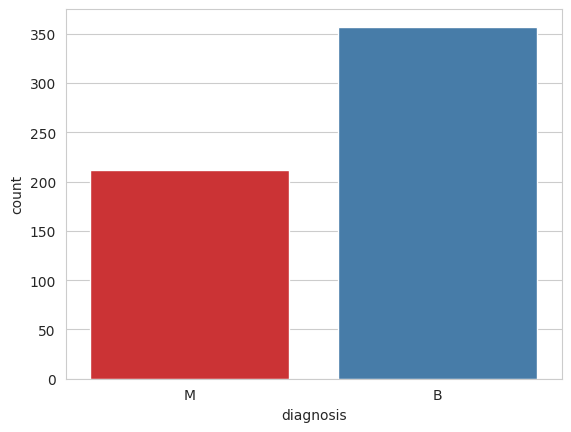

In [7]:
# Check the diagnosis classes and their distribution
_, label_distribution = np.unique(y, return_counts=True)
print(f"Malignant: {label_distribution[1]}")
print(f"Benign: {label_distribution[0]}")
sns.countplot(x=y, palette="Set1");

In [8]:
# Calculate the label classes proportions
M_proportion = label_distribution[0] / (label_distribution[1] + label_distribution[0])
B_proportion = label_distribution[1] / (label_distribution[1] + label_distribution[0])
print(f"Malignant Proportion: {M_proportion:.2f}")
print(f"Benign Proportion: {B_proportion:.2f}")

Malignant Proportion: 0.63
Benign Proportion: 0.37


While the dataset has some degree of imbalance (0.63 vs 0.37), it is not extremely imbalanced.

Now let's analyse our features

In [9]:
# Analyse features
X.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


To further inspect the data we can produce box plot and swarm visualizations to gain insights about correlations between features and class seperability. But first we need to standardize the features due to their different scaling.

In [10]:
# Standardize the features
scaler = StandardScaler()
X_standard = scaler.fit_transform(X)

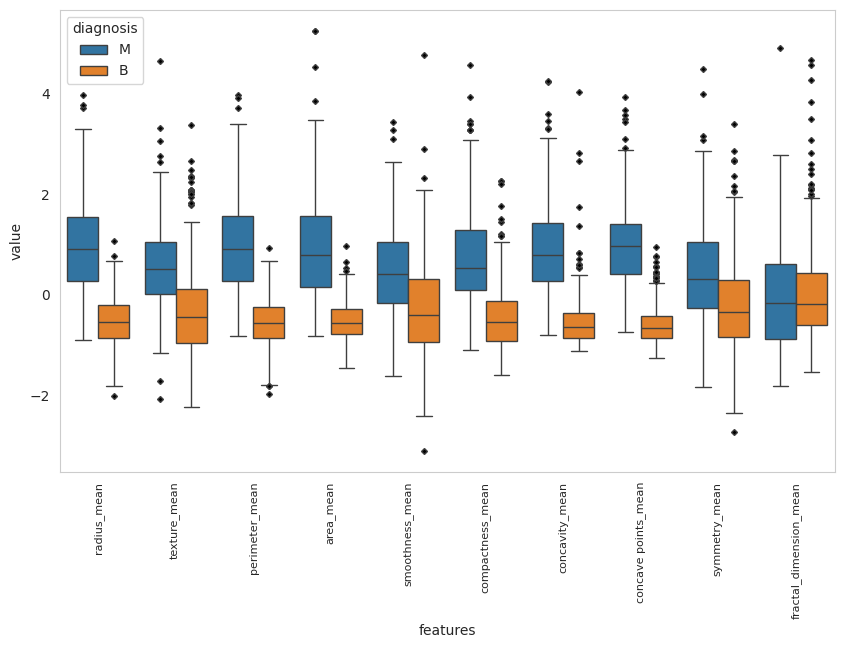

In [11]:
# Show first set of 10 features
df_stand = pd.concat([y, X_standard.iloc[:, 0:10]], axis=1)
df_stand_melt = pd.melt(df_stand, id_vars=["diagnosis"], var_name="features", value_name="value")

plt.figure(figsize=(10, 6))
sns.boxplot(x="features", y="value", hue="diagnosis", data=df_stand_melt,
            flierprops=dict(marker="D", color="black", markersize=3, markerfacecolor="black"))
plt.grid(False)
plt.xticks(rotation=90, fontsize=8)
plt.show()

To interpret the plot above let's analyse the features. The boxes of the features radius_mean, area_mean and concavity_mean seem to make a notable distinction from Malignant and Benign, meaning there is a strong class seperability, and therefore they will be very relevant for classification. However, the feature fractal_dimension_mean does not make a clear distinction between the two label classes, so it will be less relevant for classification. Another important observation is that same features are correlated to each other, we know this not only by looking at the plot but also due to our real world intuition, e.g. the features radius_mean and area_mean are naturally correlated to each other, and therefore we can keep only one.

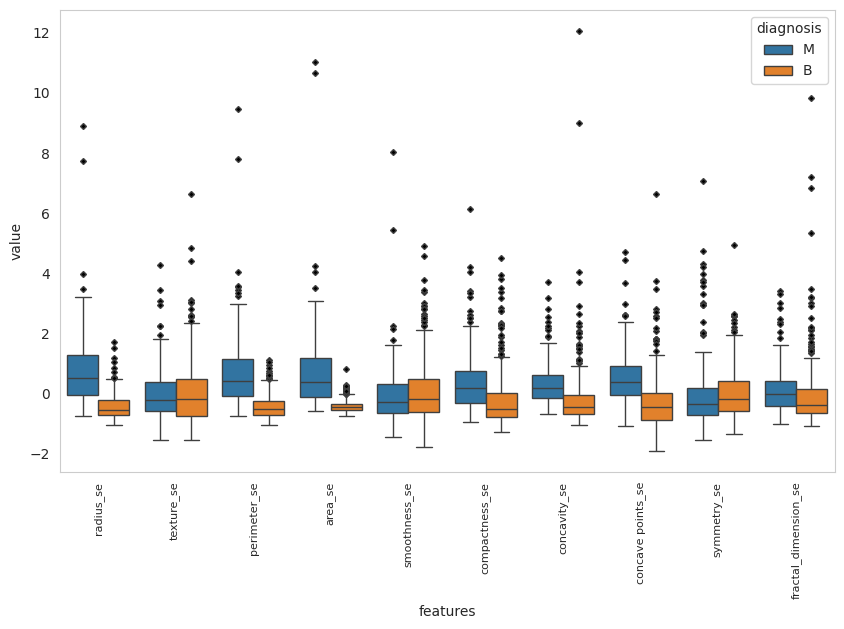

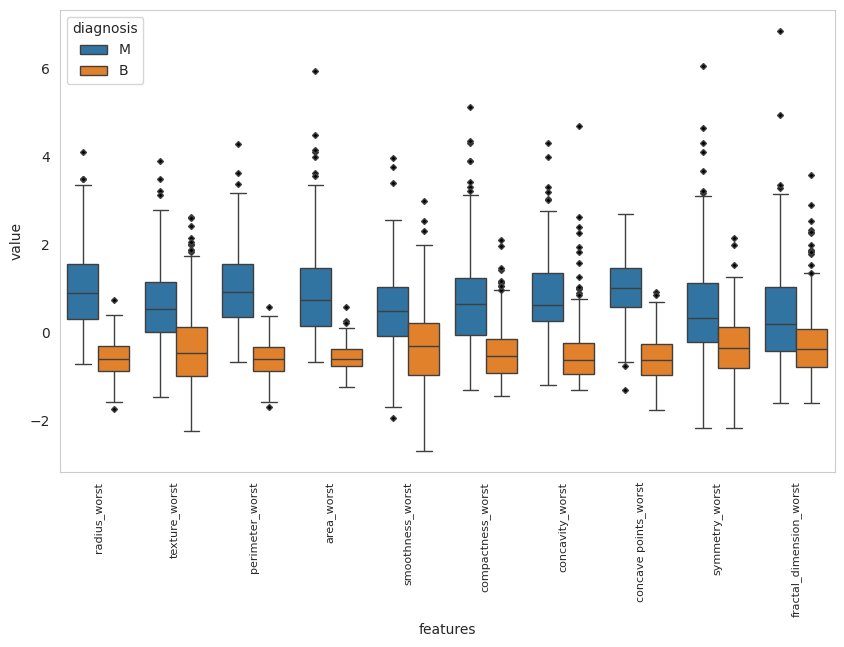

In [12]:
# Show the remaining 2 sets containing 10 features each
for i in range(1, 3):
    df_stand = pd.concat([y, X_standard.iloc[:, i*10:(i+1)*10]], axis=1)
    df_stand_melt = pd.melt(df_stand, id_vars=["diagnosis"], var_name="features", value_name="value")
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="features", y="value", hue="diagnosis", data=df_stand_melt,
                flierprops=dict(marker="D", color="black", markersize=3, markerfacecolor="black"))
    plt.grid(False)
    plt.xticks(rotation=90, fontsize=8)
    plt.show()

In this last plot we can see a couple more features that seem correlated, such as the concavity_worst and the concave points_worst. We can check the correlation by calculating the Pearson coefficient between them.

In [13]:
# Claculate correlation between concavity_worst and concave points_worst
correlation = X_standard["concavity_worst"].corr(X_standard["concave points_worst"])
correlation

0.8554338603439995

A Pearson coefficient of 0.86 suggests that the two features are strongly correlated. This means there is a strong linear relationship between them, where a change in one feature is likely associated with a substantial change in the other feature in the same direction. These type of discoveries will help us during feature selection.

We can observe all correlations between features using a heatmap.

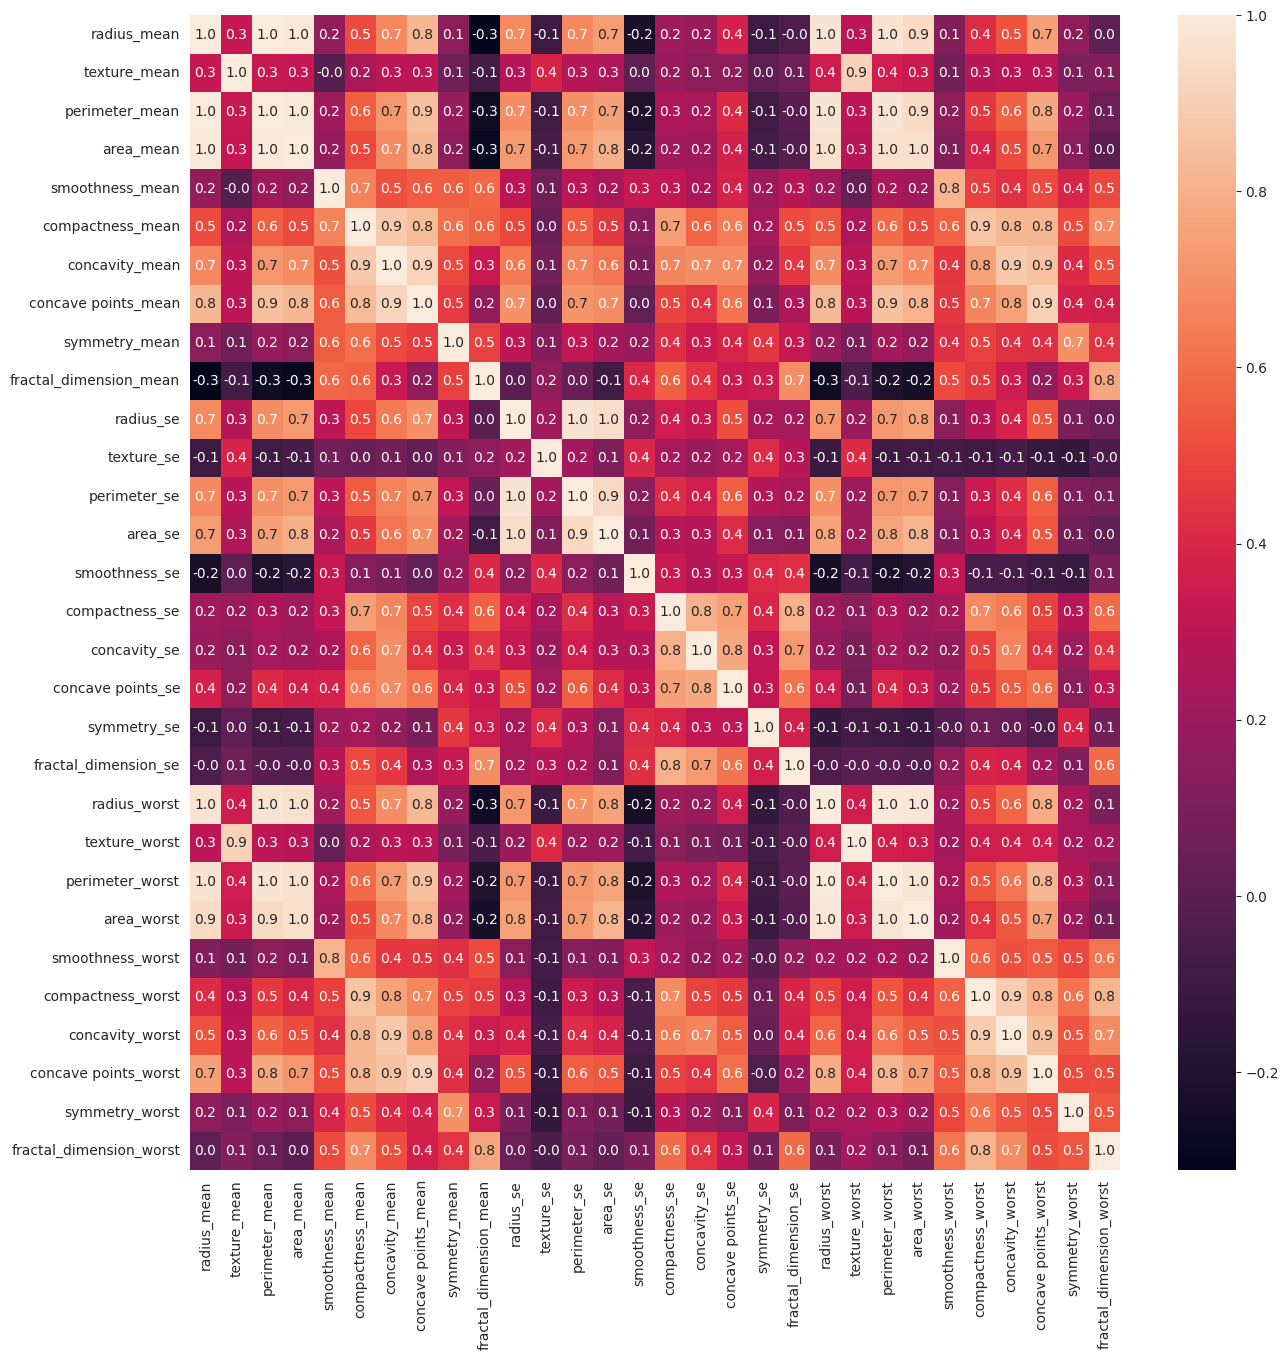

In [14]:
# Correlation map
_, axes = plt.subplots(figsize=(15, 15))
sns.heatmap(X_standard.corr(), annot=True, fmt= '.1f', ax=axes)
plt.show();

Lastly we will end our visualizations with swarm plots. These plots allow easier analysis of the features class seperability.

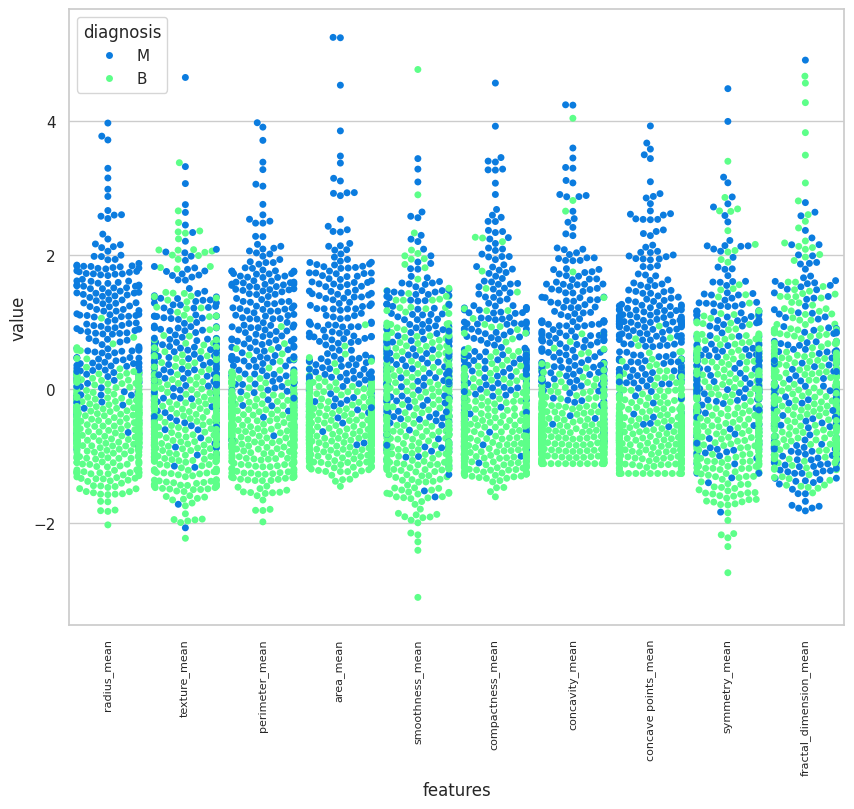

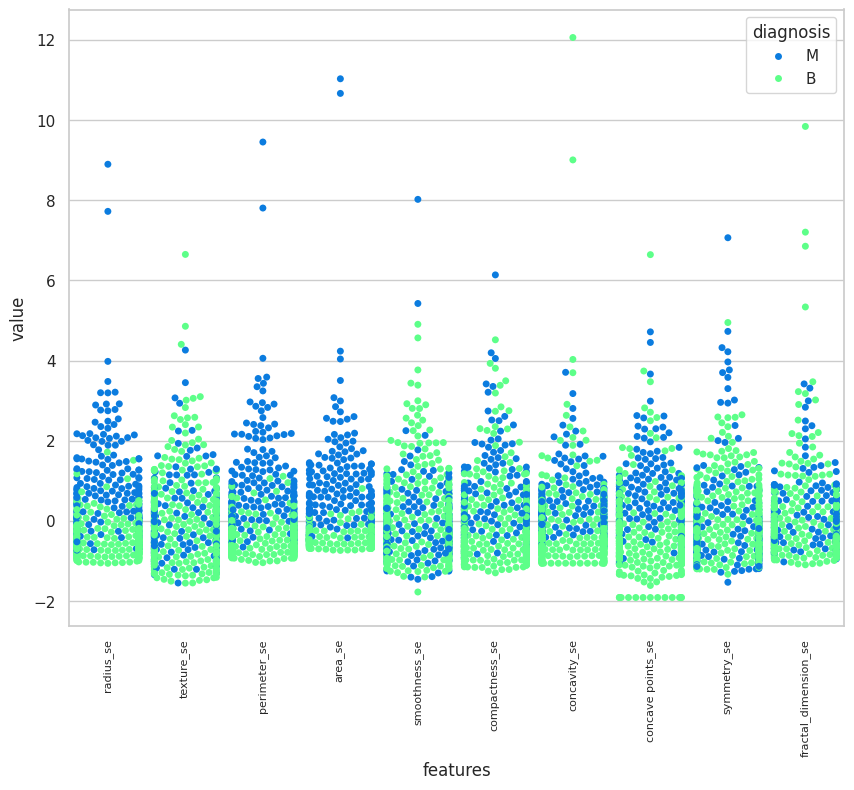

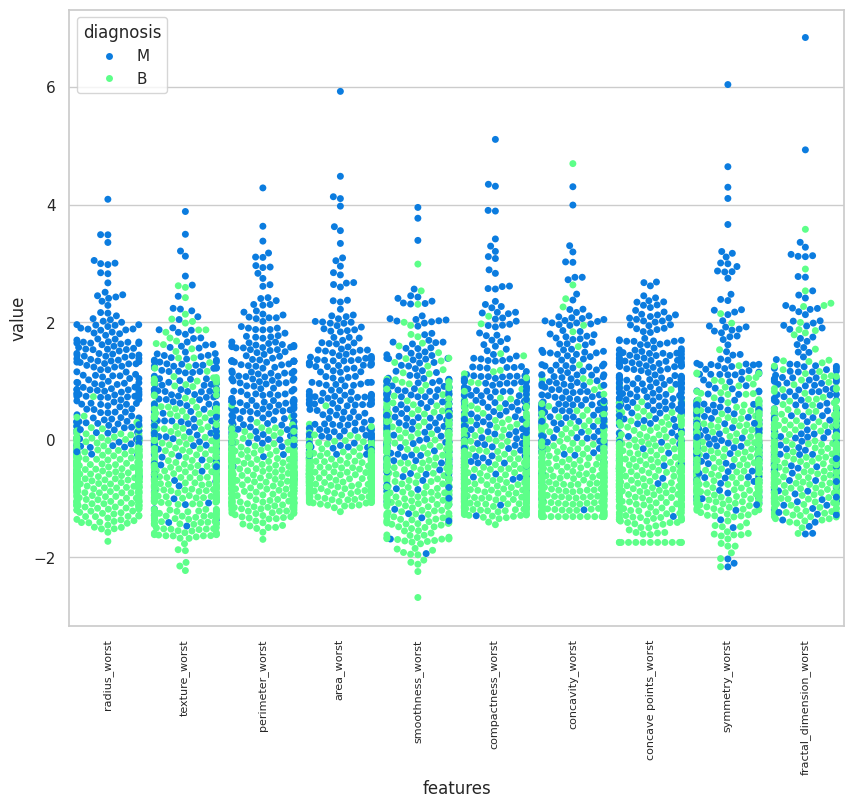

In [15]:
# Show 3 plots each containing 10 features
sns.set(style="whitegrid", palette="muted")

for i in range(0, 3):
    df_stand = pd.concat([y, X_standard.iloc[:, i*10:i*10+10]],axis=1)
    df_stand_melt = pd.melt(df_stand, id_vars="diagnosis", var_name="features", value_name='value')
    plt.figure(figsize=(10, 8))
    sns.swarmplot(x="features", y="value", hue="diagnosis", data=df_stand_melt, palette={"M": "#0b7cdf", "B": "#5dff89"})
    plt.xticks(rotation=90, fontsize=8)
    plt.show()

From the plots above we can see features that effectively distinguish between classes (e.g. area_worst and concavity_worst in the last plot), but also features where the malignant and benign data points are mixed, possibly making it hard to classify using these features.

**<span style="font-size: 24px;">Feature Selection**

Now it's time to remove the highly correlated features. We will start by revisiting the correlation heatmap.

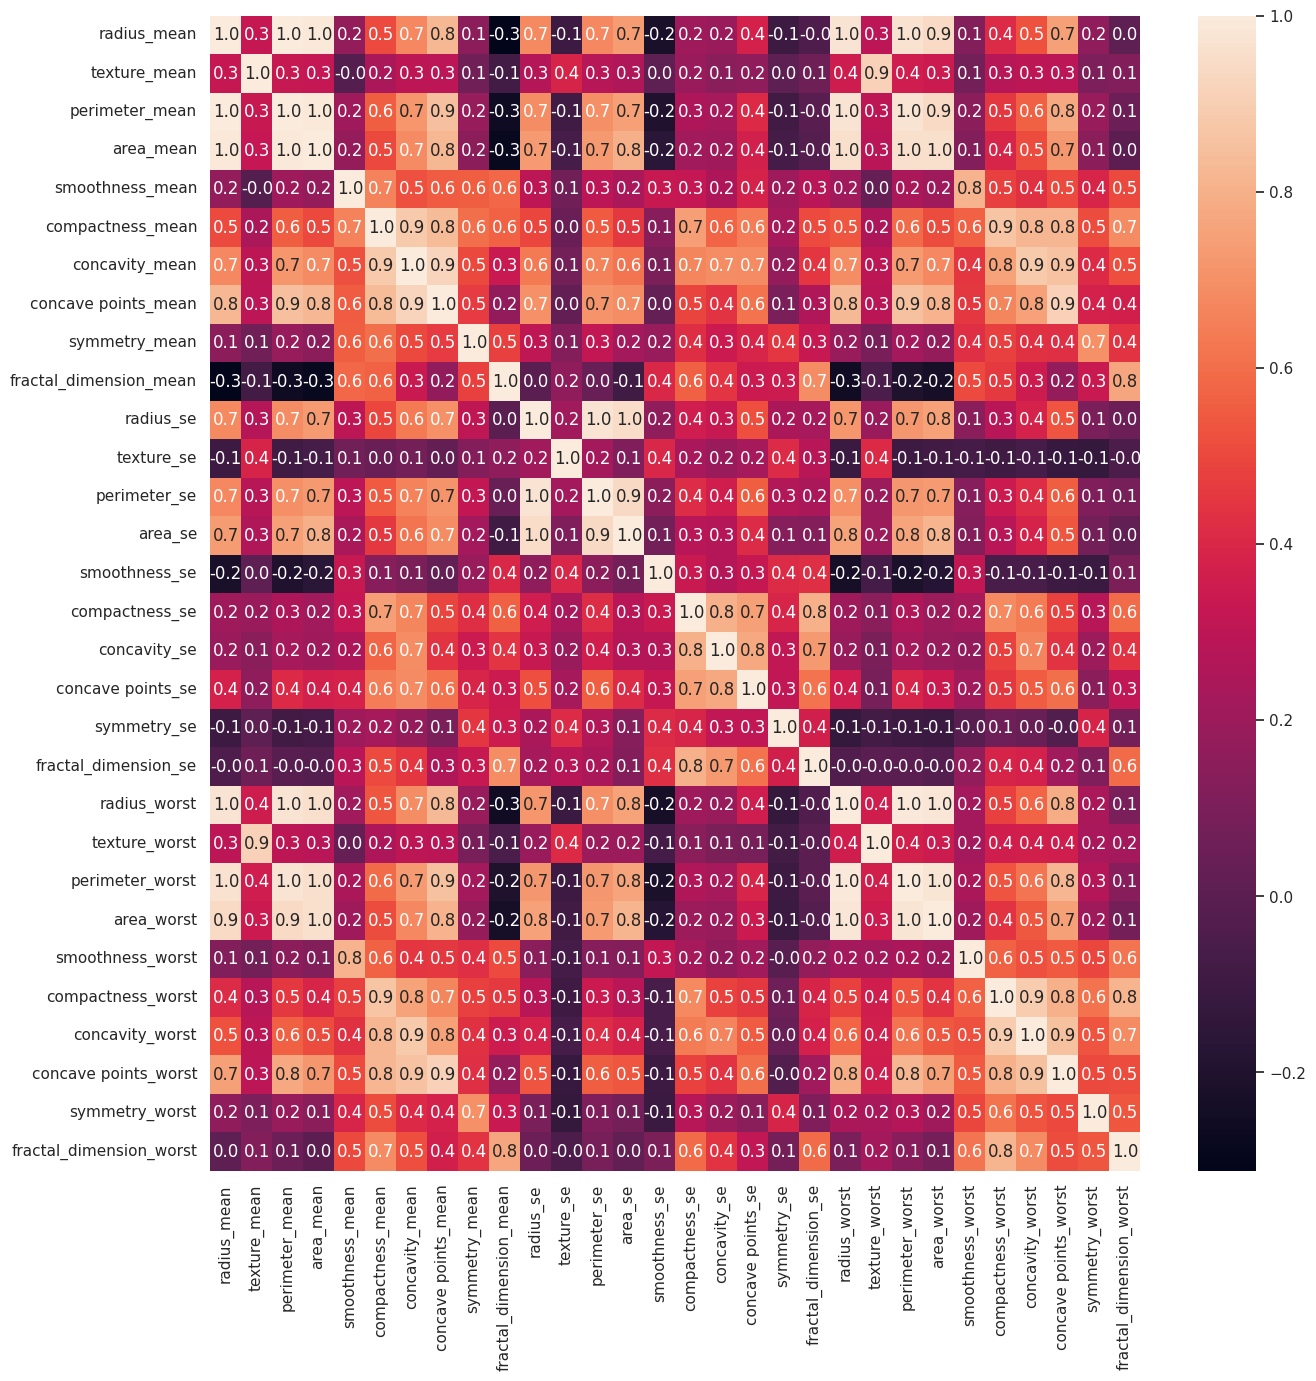

In [16]:
# Correlation map
_, axes = plt.subplots(figsize=(15, 15))
sns.heatmap(X_standard.corr(), annot=True, fmt= '.1f', ax=axes)
plt.show();

We will remove all features with Pearson coefficient higher than 0.8.

In [17]:
# Drop highly correlated features
feature_drop_list = ["radius_mean", "texture_mean", "perimeter_mean", "area_mean", "compactness_mean", "concavity_mean", "concave points_mean",
                     "radius_se", "perimeter_se", "radius_worst", "perimeter_worst", "compactness_worst", "concavity_worst"]

X_uncorrelated = X_standard.drop(feature_drop_list, axis=1)
X_uncorrelated.head()

,smoothness_mean,symmetry_mean,fractal_dimension_mean,texture_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,texture_worst,area_worst,smoothness_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1.567087,2.215566,2.253764,-0.564768,2.485391,-0.213814,1.315704,0.723390,0.660239,1.147747,0.906286,-1.358098,1.999478,1.306537,2.294058,2.748204,1.935312
1,-0.826235,0.001391,-0.867889,-0.875473,0.741749,-0.604819,-0.692317,-0.440393,0.259933,-0.804742,-0.099356,-0.368879,1.888827,-0.375282,1.086129,-0.243675,0.280943
2,0.941382,0.938859,-0.397658,-0.779398,1.180298,-0.296744,0.814257,0.212889,1.423575,0.236827,0.293301,-0.023953,1.455004,0.526944,1.953282,1.151242,0.201214
3,3.280667,2.864862,4.906602,-0.110312,-0.288125,0.689095,2.741868,0.818798,1.114027,4.728520,2.045711,0.133866,-0.549538,3.391291,2.173873,6.040726,4.930672
4,0.280125,-0.009552,-0.561956,-0.789549,1.189310,1.481763,-0.048477,0.827742,1.143199,-0.360775,0.498889,-1.465481,1.219651,0.220362,0.728618,-0.867590,-0.396751


Visualize the new heatmap without highly correlated features.

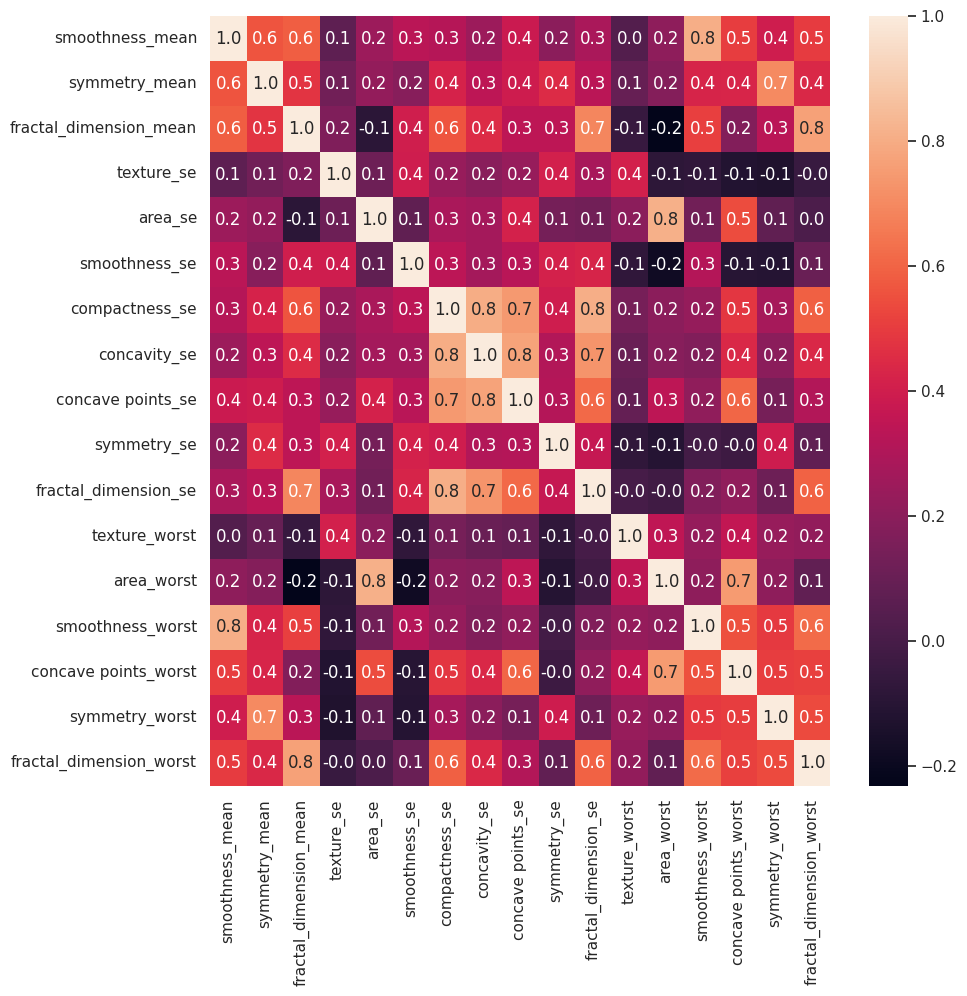

In [18]:
# Correlation map with filtered features
_, axes = plt.subplots(figsize=(10, 10))
sns.heatmap(X_uncorrelated.corr(), annot=True, fmt= '.1f', ax=axes)
plt.show();

Now we can test how a Random Forest Classifier model performs using this filtered dataset. The reason we are using a tree based model is due to the "feature_importances" method available with these models which rates the importance of each feature regarding how relevant they are for classification. We can use this method to filter out the dataset even further.

The manual feature selection that we performed before was essential, because it not only reduced the size of the dataset allowing models to train faster, but mainly because if we did not perform such selection than the output of the "feature_importances" method would likely contain correlated features.

Before training the model is important to encode the target label.

In [19]:
# Encode diagnosis to numerical values where M = 1 and B = 0
def diagnosis_encoder(value):
    if value == "M": return 1
    else: return 0
    
y_encoded = y.apply(diagnosis_encoder)

In [20]:
# Train a Random Forest Classifier
model = RandomForestClassifier(random_state=42)      
cv_scores = cross_val_score(model, X_uncorrelated, y_encoded, cv=5, scoring='recall') # Recall is the recommend metric for cancer related datasets

print(f"Mean Cross Validation Recall: {cv_scores.mean():.2f}")

Mean Cross Validation Recall: 0.92


The Random Forest Classifier obtained 0.92 recall. We can use the "feature_importances" method to find out the most relevant features.

                    Feature  Importance
12               area_worst    0.345179
14     concave points_worst    0.228340
4                   area_se    0.121752
11            texture_worst    0.054495
7              concavity_se    0.036966
8         concave points_se    0.031891
13         smoothness_worst    0.031779
15           symmetry_worst    0.028573
16  fractal_dimension_worst    0.021355
0           smoothness_mean    0.018637
6            compactness_se    0.014280
5             smoothness_se    0.012515
2    fractal_dimension_mean    0.012031
1             symmetry_mean    0.011431
3                texture_se    0.010902
10     fractal_dimension_se    0.009969
9               symmetry_se    0.009905


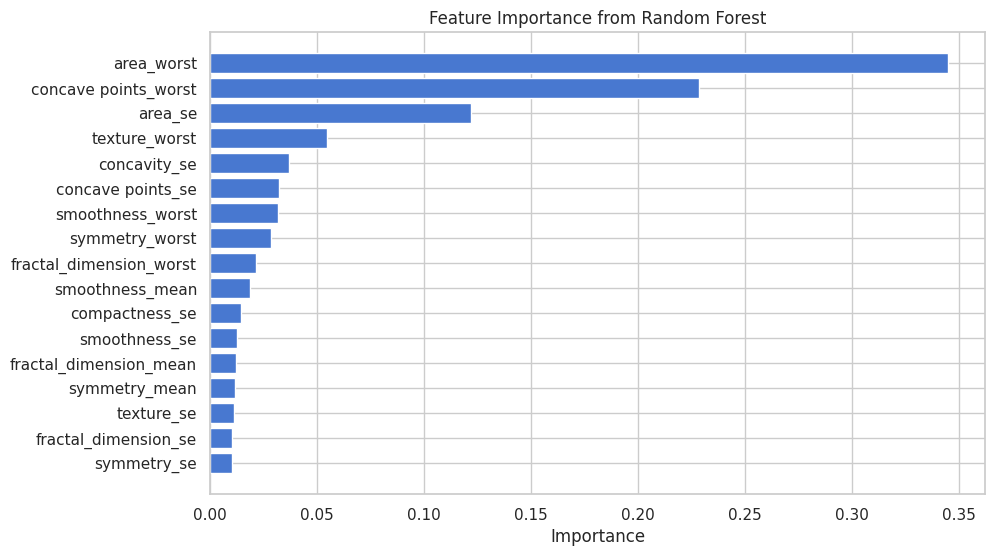

In [21]:
# Get feature_importances from model
model.fit(X_uncorrelated, y_encoded)
features_importances = model.feature_importances_
features_importances_df = pd.DataFrame({"Feature": X_uncorrelated.columns, "Importance": features_importances})

# Sort the features by importance
features_importances_df.sort_values(by=["Importance"], ascending=False, inplace=True)
print(features_importances_df)

# Plot the features importance
plt.figure(figsize=(10, 6))
plt.barh(features_importances_df["Feature"], features_importances_df["Importance"])
plt.xlabel("Importance")
plt.title("Feature Importance from Random Forest")
plt.gca().invert_yaxis()
plt.show();

From the plot above we learn that the "are_worst" and "concave points_worst" are by far the most important features for the classification. We this information we need to decide how many and which features we want to keep. I decided to first try the top 8 because it seems to be the last significant drop off.

In [22]:
# Select the top N important features
N = 4  # number of features to keep
top_features = features_importances_df['Feature'].head(N).values
X_filtered = X_uncorrelated[[col for col in X_uncorrelated.columns if col in top_features]]

In [23]:
# Create Random Forest model
model_rf = RandomForestClassifier(random_state=42)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(model_rf, X_filtered, y_encoded, cv=5, scoring='recall')

print(f"Mean Cross Validation Recall: {np.mean(cv_scores):.2f}")

Mean Cross Validation Recall: 0.92


It seems with 4 features the recall remains the same, so we will experiment other values for top N important features. We can do this with recursive feature elimination with cross validation.

In [24]:
# Find the best features and how many do we need
model = RandomForestClassifier(random_state=42)
rfecv = RFECV(model, cv=5, scoring='recall')
rfecv.fit(X_uncorrelated, y_encoded)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_uncorrelated.columns[rfecv.support_])

Optimal number of features : 9
Best features : Index(['area_se', 'concavity_se', 'concave points_se', 'texture_worst',
       'area_worst', 'smoothness_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')


So now we know the optimal amount of features is 9 and what those features are. So let's test and see if we can improve the recall.

In [25]:
# Drop all the unnecessary columns
X_filtered = X_uncorrelated[[col for col in X_uncorrelated.columns[rfecv.support_]]]

# Create Random Forest model and perform cross-validation
model = RandomForestClassifier(random_state=42)
cv_scores = cross_val_score(model, X_filtered, y_encoded, cv=5, scoring='recall')

print(f"Mean Cross Validation Recall: {np.mean(cv_scores):.2f}")

Mean Cross Validation Recall: 0.94


Great! We improved the recall from 0.92 to 0.94.

From now forward we will experiment other models besides Random Forest models. All the experiments will be performed using only the 9 optimal features (already standardized) and the encoded target label.

**<span style="font-size: 24px;">Model Development**

We will now train and evaluate multiple models. Let's set the previous Random Forest model as the baseline model, meaning our objetive will be to beat the 0.94 recall score.

We will test 5 models: Random Forest, Logistic Regression, KNN, SVM and XGBoost.

In [39]:
# Initialize models
models = {
    "RandomForest": RandomForestClassifier(random_state=42),  # Set random_state for reproducibility
    "LogisticRegression": LogisticRegression(random_state=42),  # Set random_state for reproducibility
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(),
    "XGBoost": XGBClassifier(random_state=42)  # Set random_state for reproducibility
}

results = []

# Loop through each model and perform cross-validation
for model_name, model in models.items():
    cv_scores = cross_val_score(model, X_filtered, y_encoded, cv=5, scoring='recall')
    
    model_score_mean = np.mean(cv_scores)
    
    results.append({
        'Model': model_name,
        'Mean Recall': model_score_mean,
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Mean Recall', ascending=False)

In [47]:
# Format the results dataframe to 2 decimal places
results_df_formatted = results_df
results_df_formatted["Mean Recall"] = results_df_formatted["Mean Recall"].apply(lambda x: f"{x:.2f}")

print(results_df_formatted)

                Model Mean Recall
3                 SVM        0.96
1  LogisticRegression        0.94
0        RandomForest        0.94
4             XGBoost        0.94
2                 KNN        0.91


From the table above we conclude the model SVM obtained the highest recall with a 0.96 recall score compared to the baseline's 0.94 score.

In [49]:
# Calculate the classification report of the best model
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_encoded, test_size=0.2, random_state=42)

model = SVC()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96        71
           1       0.93      0.95      0.94        43

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114

